In [2]:
import pandas as pd
import numpy as np 
from datetime import datetime
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [ ]:
# GDP_NOM_SECTORS: Nominal GDP of different sectors
# GDP_YOY_SECTORS: Year-on-year real GDP growth rates for different sectors
# AR: Agriculture, Forestry and Fisheries
# ID: Industrial
# CO: Construction
# WH: Wholesale and retail trade
# TR: Transportation, storage and postal services
# AC: Accommodation and catering
# FI: Finance
# RE: Real Estate
# IN: Information transmission, software and information technology services
# LE: Leasing and business services
# OT: Other Industries

In [5]:
GDP_NOM_SECTORS = pd.read_csv('GDP_NOM_SECTORS.csv').set_index('QTR')
GDP_YOY_SECTORS = pd.read_csv('GDP_YOY_SECTORS.csv').set_index('QTR')
GDP_YOY = pd.read_csv('GDP_YOY.csv').set_index('QTR')
GDP_YOY_SECTORS['OT'] = (GDP_NOM_SECTORS[['IN', 'LE', 'OT']].sum(axis = 1) / np.multiply(GDP_NOM_SECTORS[['IN', 'LE', 'OT']] , 1 / (1 + GDP_YOY_SECTORS[['IN', 'LE', 'OT']]/ 100)).sum(axis = 1) - 1 ) * 100
GDP_YOY_SECTORS = GDP_YOY_SECTORS.drop(columns=['IN','LE'])
GDP_NOM_SECTORS['OT'] = GDP_NOM_SECTORS[['IN', 'LE', 'OT']].sum(axis = 1)
GDP_NOM_SECTORS = GDP_NOM_SECTORS.drop(columns=['IN','LE'])
GDP_YOY_SECTORS

,AR,ID,CO,WH,TR,AC,FI,RE,OT
QTR,,,,,,,,,
1992-03,8.9,18.3,18.1,11.7,7.8,24.2,4.0,18.7,8.000000
1992-06,6.1,20.0,20.6,10.2,9.4,25.5,5.9,21.6,12.700000
1992-09,3.4,21.0,22.1,11.8,16.0,29.6,8.2,27.9,14.400000
1992-12,3.5,24.8,21.6,8.8,8.3,28.5,7.8,34.7,11.800000
1993-03,5.0,20.8,22.9,9.5,10.7,11.0,10.1,17.4,13.600000
...,...,...,...,...,...,...,...,...,...
2021-12,6.4,3.8,-2.1,5.9,4.0,4.7,5.5,-2.9,6.085922
2022-03,6.1,6.4,1.4,3.9,2.1,-0.3,5.1,-2.0,5.928831
2022-06,4.5,0.4,3.6,-1.8,-3.5,-5.3,5.9,-7.0,0.814498


In [6]:
from rpy2.robjects import r
from rpy2.robjects.packages import importr
from rpy2.robjects import globalenv
from rpy2.robjects import pandas2ri
pandas2ri.activate()

BVAR = importr("BVAR")

Unable to determine R home: [WinError 2] The system cannot find the file specified


In [36]:
from tqdm import tqdm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import itertools

mse_set = []
for _lambda, _alpha,_lag in tqdm(itertools.product([0.1,0.2,0.3,0.4],[0.3,0.4,0.5,0.6],[4])):
    gdp_yoy_pred_lag0_list = []
    gdp_yoy_pred_lag1_list = []

    for i in  range(79, len(GDP_YOY_SECTORS) ):
        rdf = pandas2ri.py2rpy(GDP_YOY_SECTORS.iloc[:i])
        globalenv['rdf'] = rdf
        globalenv['lambda'] = _lambda
        globalenv['alpha'] = _alpha
        globalenv['lag'] = _lag
        rscript = """
        bv_priors <- bv_mn( 
        lambda = bv_lambda(mode = lambda ),
        alpha = bv_alpha(mode = alpha), 
        var = 10000000, 
        b = 1
        ) 
        x <- bvar(rdf, lags = lag, n_draw = 1000L, n_burn = 200L, priors = bv_priors(), verbose = FALSE)
        predict(x) <- predict(x, horizon = 2)
        irf(x) <- irf(x, horizon = 2, fevd = FALSE)
        summary(x)
        """
        result = r(rscript)
        gdp_yoy_sectors_pred_lag0 = np.median(result[0][10][0],  axis =0)[0]
        gdp_yoy_sectors_pred_lag1 = np.median(result[0][10][0],  axis =0)[1]
        gdp_yoy_pred_lag0 = np.dot(np.array(GDP_NOM_SECTORS.iloc[i-1] / GDP_NOM_SECTORS.iloc[i-1].sum()), gdp_yoy_sectors_pred_lag0.T)
        gdp_yoy_pred_lag1 = np.dot((np.array(GDP_NOM_SECTORS.iloc[i-1]) * (gdp_yoy_sectors_pred_lag0 / 100 + 1)) / (np.array(GDP_NOM_SECTORS.iloc[i-1]) * (gdp_yoy_sectors_pred_lag0 / 100 + 1)).sum(), gdp_yoy_sectors_pred_lag1.T)
        gdp_yoy_pred_lag0_list.append(gdp_yoy_pred_lag0)
        gdp_yoy_pred_lag1_list.append(gdp_yoy_pred_lag1)

    mse_set.append([_lambda,_alpha,_lag ,\
        r2_score(gdp_yoy_pred_lag0_list[1:] , list(GDP_YOY['YOY'].iloc[80:])) , \
        r2_score(gdp_yoy_pred_lag1_list[:-1] , list(GDP_YOY['YOY'].iloc[80:])), \
        r2_score(gdp_yoy_pred_lag0_list[1:] + gdp_yoy_pred_lag1_list[:-1] ,  list(GDP_YOY['YOY'].iloc[80:]) + list(GDP_YOY['YOY'].iloc[80:])) ,\
        mean_squared_error(gdp_yoy_pred_lag0_list[1:] , list(GDP_YOY['YOY'].iloc[80:])) , \
        mean_squared_error(gdp_yoy_pred_lag1_list[:-1] , list(GDP_YOY['YOY'].iloc[80:])), \
        mean_squared_error(gdp_yoy_pred_lag0_list[1:] + gdp_yoy_pred_lag1_list[:-1] ,  list(GDP_YOY['YOY'].iloc[80:]) + list(GDP_YOY['YOY'].iloc[80:])) ]) 

48it [2:41:50, 202.30s/it]


In [47]:
mse_set_df = pd.DataFrame(mse_set).sort_values(8) 
mse_set_df = mse_set_df.rename(columns = { 0: 'lambda', 1:'alpha', 2:   'lag', 8 :'mean_squared_error'})
mse_set_df

,lambda,alpha,lag,3,4,5,6,7,mean_squared_error
12,0.2,0.3,4,-0.576884,-1.186346,-0.867612,12.085795,16.046371,14.066083
6,0.1,0.5,4,-0.537991,-1.016178,-0.771396,12.415019,16.281074,14.348047
44,0.4,0.5,6,-0.612929,-1.186016,-0.884625,12.588898,16.165051,14.376974
26,0.3,0.3,6,-0.604555,-1.184609,-0.880880,12.581277,16.275819,14.428548
11,0.1,0.6,6,-0.717700,-1.129671,-0.925604,12.442488,16.462780,14.452634
30,0.3,0.5,4,-0.543529,-1.021255,-0.772704,12.761324,16.144508,14.452916
14,0.2,0.3,6,-0.521940,-1.094376,-0.790870,12.962000,16.047547,14.504773
33,0.3,0.6,4,-0.594148,-1.107537,-0.840411,12.832865,16.180077,14.506471
21,0.2,0.6,4,-0.627263,-1.054180,-0.840705,12.496139,16.646955,14.571547
3,0.1,0.4,4,-0.624827,-1.013128,-0.822864,12.506009,16.654936,14.580473


In [7]:
import matplotlib.pyplot as plt
import scienceplots
from mpl_toolkits.axes_grid1 import make_axes_locatable

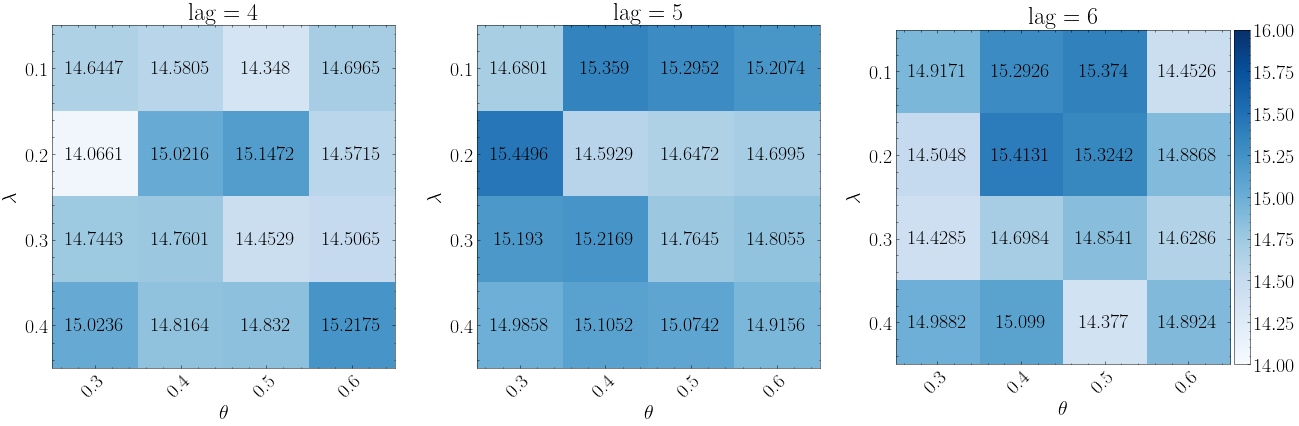

In [49]:

plt.style.use('science')
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.figsize'] = (20,8) 
plt.rcParams['font.size'] =  20.0
plt.rcParams['font.weight'] = 'bold'

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True,   figsize=(18, 6))


lambda_ = [0.1, 0.2, 0.3, 0.4]
alpha = [0.3,0.4,0.5,0.6]

harvest0 = np.array(round(mse_set_df[mse_set_df['lag'] == 4].sort_values(['lambda','alpha'])['mean_squared_error'] ,4)).reshape(4,4)
im = ax0.imshow(harvest0, cmap='Blues', vmin=14, vmax=16)
# Show all ticks and label them with the respective list entries
ax0.set_xticks(np.arange(len(alpha)), labels=alpha)
ax0.set_yticks(np.arange(len(lambda_)), labels=lambda_)
ax0.set_xlabel(r'$\theta$')
ax0.set_ylabel(r'$\lambda$')

# Rotate the tick labels and set their alignment.
plt.setp(ax0.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
         
for i in range(len(alpha)):
    for j in range(len(lambda_)):
        text = ax0.text(j, i, harvest0[i, j],
                       ha="center", va="center", color='k') 
ax0.set_title("lag = 4")

harvest1 = np.array( round(mse_set_df[mse_set_df['lag'] == 5].sort_values(['lambda','alpha'])['mean_squared_error'] ,4)).reshape(4,4)
im = ax1.imshow(harvest1, cmap='Blues', vmin=14, vmax=16 )
# Show all ticks and label them with the respective list entries
ax1.set_xticks(np.arange(len(alpha)), labels=alpha)
ax1.set_yticks(np.arange(len(lambda_)), labels=lambda_)
ax1.set_xlabel(r'$\theta$')
ax1.set_ylabel(r'$\lambda$')

# Rotate the tick labels and set their alignment.
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
         
for i in range(len(alpha)):
    for j in range(len(lambda_)):
        text = ax1.text(j, i, harvest1[i, j],
                       ha="center", va="center", color='k') 
ax1.set_title("lag = 5")

harvest2 = np.array( round(mse_set_df[mse_set_df['lag'] == 6].sort_values(['lambda','alpha'])['mean_squared_error'] ,4)).reshape(4,4)
im = ax2.imshow(harvest2, cmap='Blues', vmin=14, vmax=16 )
# Show all ticks and label them with the respective list entries
ax2.set_xticks(np.arange(len(alpha)), labels=alpha)
ax2.set_yticks(np.arange(len(lambda_)), labels=lambda_)
ax2.set_xlabel(r'$\theta$')
ax2.set_ylabel(r'$\lambda$')

# Rotate the tick labels and set their alignment.
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
         
for i in range(len(alpha)):
    for j in range(len(lambda_)):
        text = ax2.text(j, i, harvest2[i, j],
                       ha="center", va="center", color='k') 
ax2.set_title("lag = 6")

fig.tight_layout()

divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)
plt.show()

In [13]:

rdf = pandas2ri.py2rpy(GDP_YOY_SECTORS)
globalenv['rdf'] = rdf
rscript = """
bv_priors <- bv_mn( 
lambda = bv_lambda(mode = 0.2 ),
alpha = bv_alpha(mode = 0.3 ), 
var = 10000000, 
b = 1
) 
x <- bvar(rdf, lags = 4, n_draw = 1000L, n_burn = 200L, priors = bv_priors(), verbose = FALSE)
predict(x) <- predict(x, horizon = 8)
irf(x) <- irf(x, horizon = 8, fevd = FALSE)
summary(x)
"""
result = r(rscript)
gdp_yoy_sectors_pred_lag = result[0][10][0]


In [8]:
GDP_YOY_SECTORS

,AR,ID,CO,WH,TR,AC,FI,RE,OT
QTR,,,,,,,,,
1992-03,8.9,18.3,18.1,11.7,7.8,24.2,4.0,18.7,8.000000
1992-06,6.1,20.0,20.6,10.2,9.4,25.5,5.9,21.6,12.700000
1992-09,3.4,21.0,22.1,11.8,16.0,29.6,8.2,27.9,14.400000
1992-12,3.5,24.8,21.6,8.8,8.3,28.5,7.8,34.7,11.800000
1993-03,5.0,20.8,22.9,9.5,10.7,11.0,10.1,17.4,13.600000
...,...,...,...,...,...,...,...,...,...
2021-12,6.4,3.8,-2.1,5.9,4.0,4.7,5.5,-2.9,6.085922
2022-03,6.1,6.4,1.4,3.9,2.1,-0.3,5.1,-2.0,5.928831
2022-06,4.5,0.4,3.6,-1.8,-3.5,-5.3,5.9,-7.0,0.814498


In [9]:
sectors_dict = {'AR': 'Agriculture, Forestry and Fisheries', 'ID': 'Industrial', 'CO': 'Construction', 'WH': 'Wholesale and Retail',\
    'TR': 'Transportation, Storage and Postal Services', 'AC': 'Accommodation and catering', 'FI': 'Finance', 'RE': 'Real Estate',\
        'OT': 'Other Sectors' }

In [15]:
GDP_YOY_SECTORS.index = pd.to_datetime(GDP_YOY_SECTORS.index)
GDP_YOY_SECTORS.index = GDP_YOY_SECTORS.index + pd.offsets.MonthEnd(0)
GDP_YOY_SECTORS

,AR,ID,CO,WH,TR,AC,FI,RE,OT
QTR,,,,,,,,,
1992-03-31,8.9,18.3,18.1,11.7,7.8,24.2,4.0,18.7,8.000000
1992-06-30,6.1,20.0,20.6,10.2,9.4,25.5,5.9,21.6,12.700000
1992-09-30,3.4,21.0,22.1,11.8,16.0,29.6,8.2,27.9,14.400000
1992-12-31,3.5,24.8,21.6,8.8,8.3,28.5,7.8,34.7,11.800000
1993-03-31,5.0,20.8,22.9,9.5,10.7,11.0,10.1,17.4,13.600000
...,...,...,...,...,...,...,...,...,...
2021-12-31,6.4,3.8,-2.1,5.9,4.0,4.7,5.5,-2.9,6.085922
2022-03-31,6.1,6.4,1.4,3.9,2.1,-0.3,5.1,-2.0,5.928831
2022-06-30,4.5,0.4,3.6,-1.8,-3.5,-5.3,5.9,-7.0,0.814498


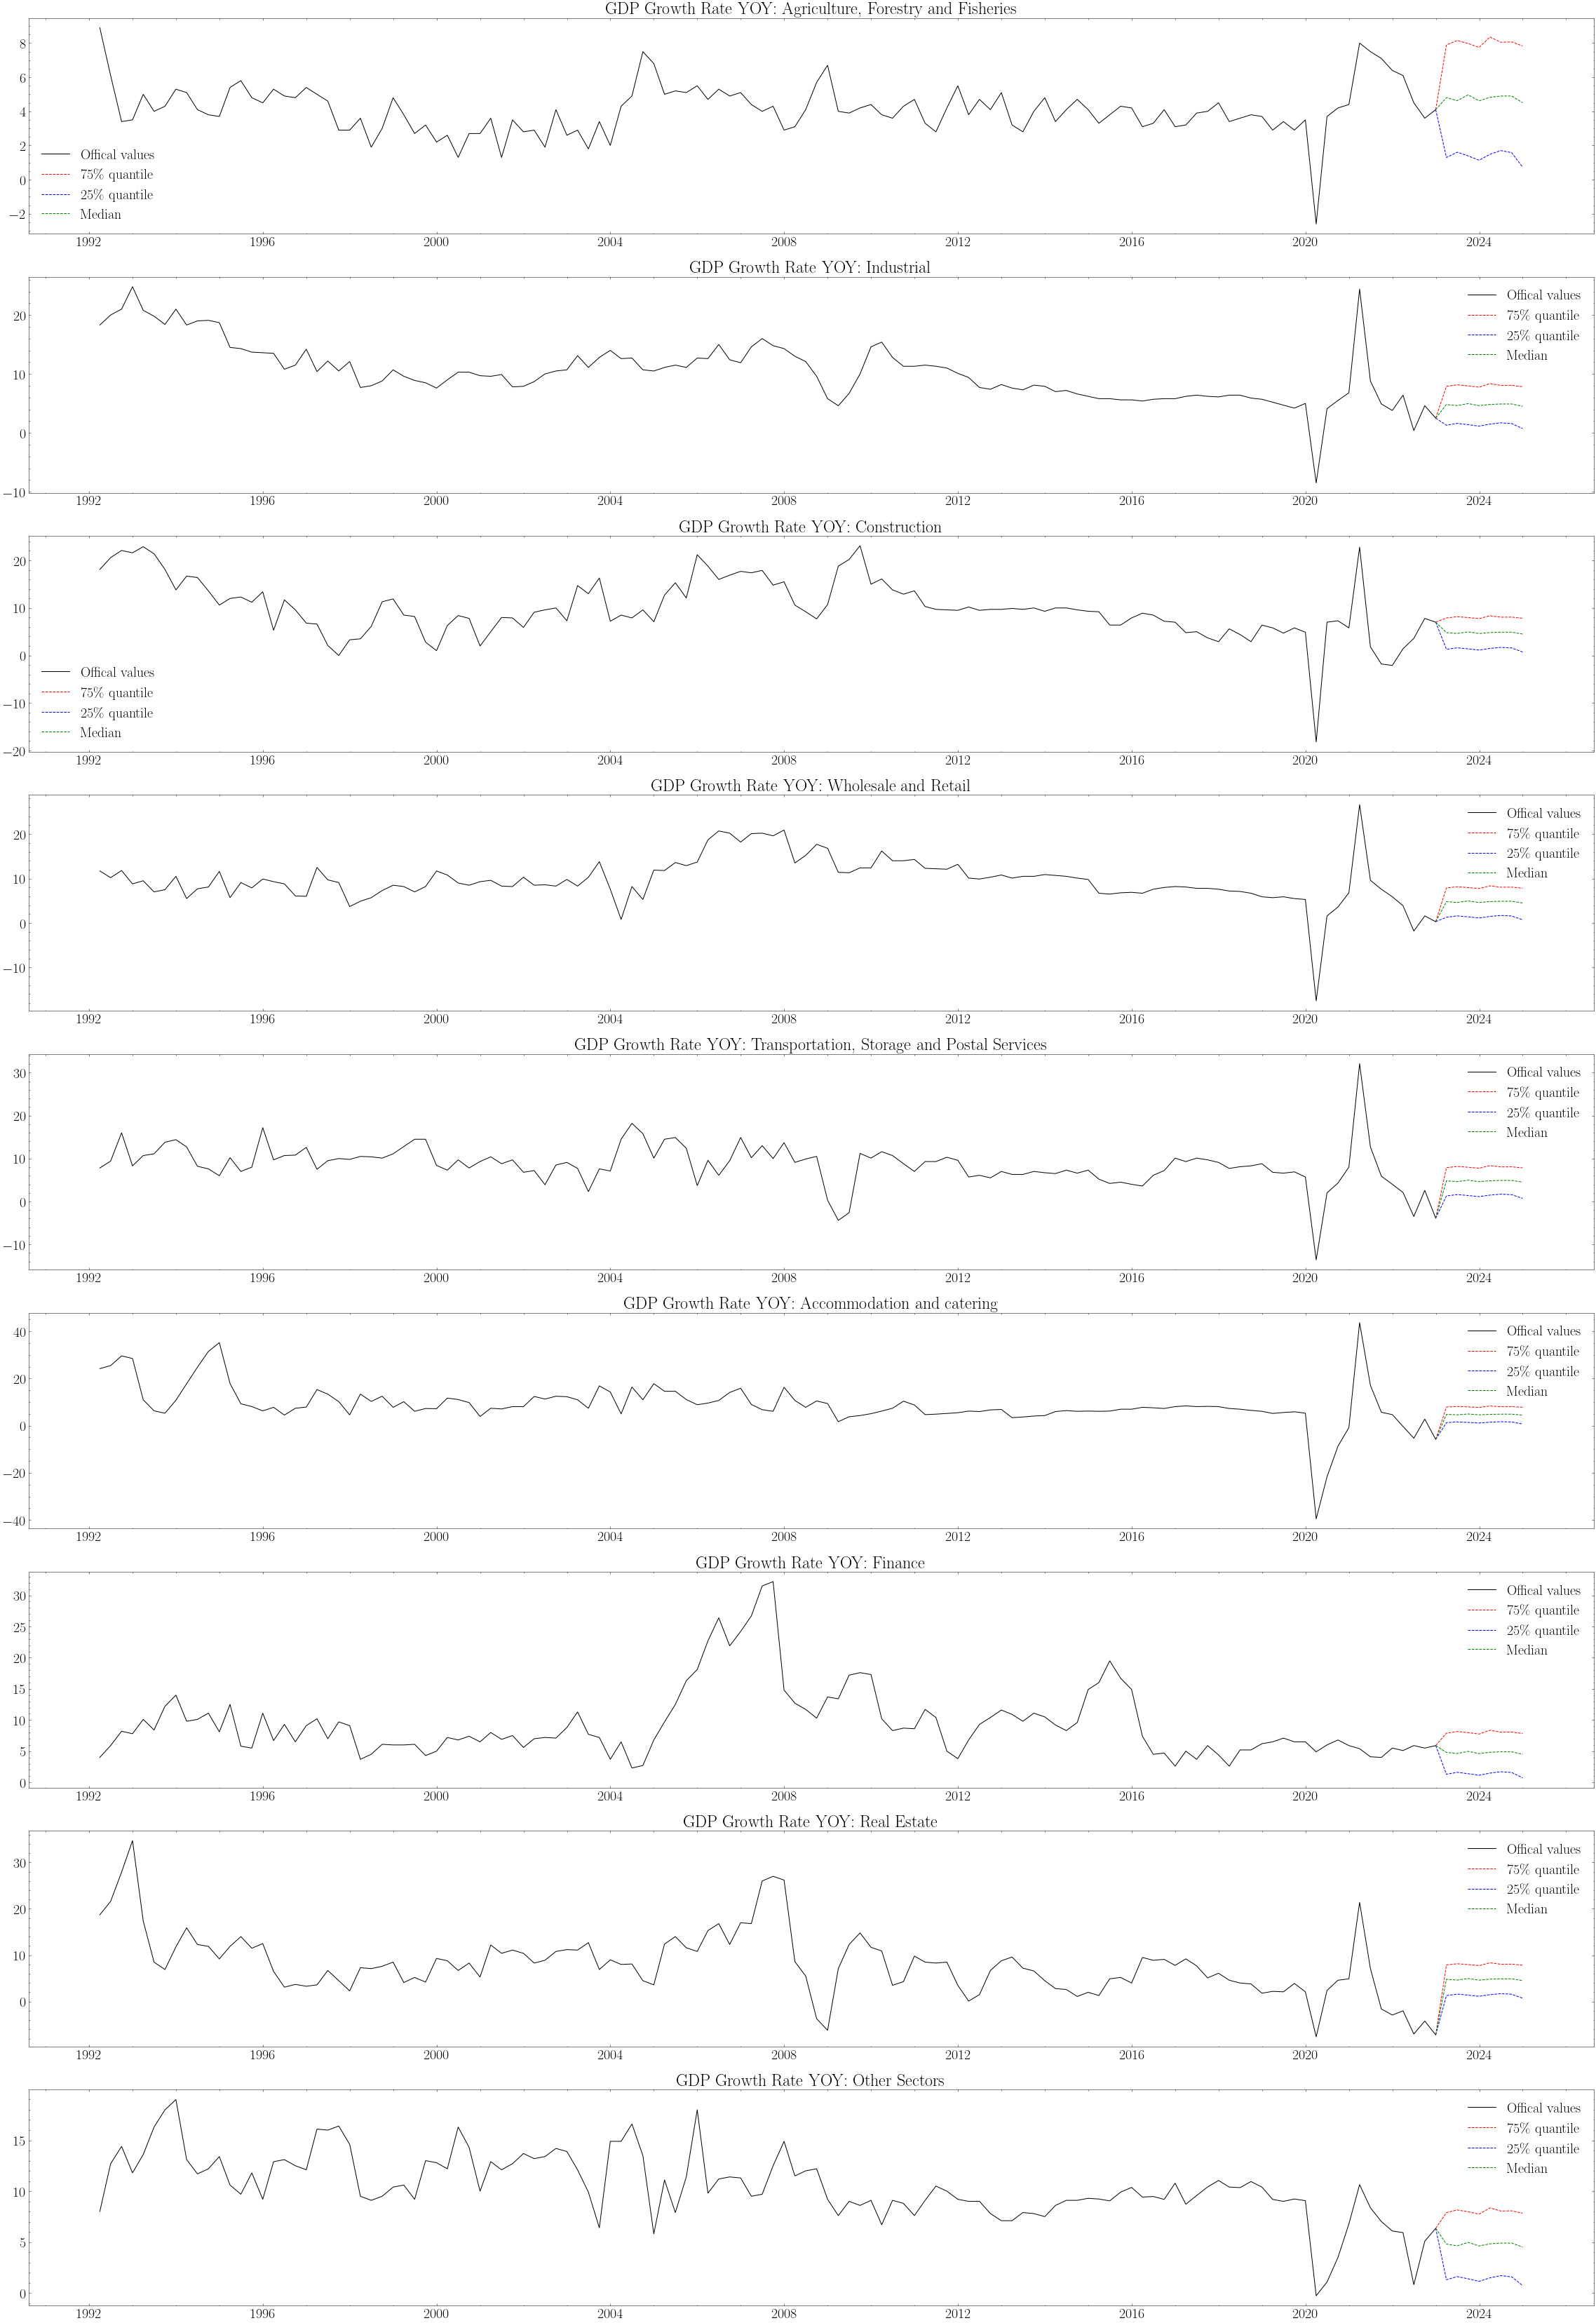

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from mpl_toolkits.axes_grid1 import make_axes_locatable


plt.style.use('science')
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.figsize'] = (20,8) 
plt.rcParams['font.size'] =  20.0
plt.rcParams['font.weight'] = 'bold'

 
fig, ax = plt.subplots(nrows=len(sectors_dict), figsize=(40, 60))
for i, count in zip(sectors_dict,range(9)):
    ax[count].plot(GDP_YOY_SECTORS.index, GDP_YOY_SECTORS[i], 'k-', label = 'Offical values')
    ax[count].plot([(GDP_YOY_SECTORS.index[-1]  + pd.offsets.QuarterEnd(j)) for j in range(9)], np.insert(np.percentile(gdp_yoy_sectors_pred_lag, 75, axis = 0)[:,0], 0, GDP_YOY_SECTORS[i].iloc[-1]),  'r--', label = '75\% quantile')
    ax[count].plot([(GDP_YOY_SECTORS.index[-1]  + pd.offsets.QuarterEnd(j)) for j in range(9)], np.insert(np.percentile(gdp_yoy_sectors_pred_lag, 25, axis = 0)[:,0], 0, GDP_YOY_SECTORS[i].iloc[-1]), 'b--', label = '25\% quantile')
    ax[count].plot([(GDP_YOY_SECTORS.index[-1]  + pd.offsets.QuarterEnd(j)) for j in range(9)], np.insert(np.median(gdp_yoy_sectors_pred_lag, axis = 0)[:,0], 0, GDP_YOY_SECTORS[i].iloc[-1]),  'g--', label = 'Median')
    ax[count].set_title('GDP Growth Rate YOY: ' + sectors_dict[i])
    ax[count].legend()

plt.show()

In [17]:
from datetime import datetime, timedelta

def last_day_of_next_quarter(date):
    next_quarter = (date.month - 1) // 3 + 2
    next_quarter_year = date.year
    if next_quarter == 5:
        next_quarter = 1
        next_quarter_year += 1
        next_quarter_end_month = (next_quarter - 1) * 3 + 4
        next_quarter_end = datetime(next_quarter_year, next_quarter_end_month, 1) - timedelta(days=1)
    elif next_quarter == 4:
        next_quarter = 4
        next_quarter_end_month = (next_quarter - 1) * 3 + 3
        next_quarter_end = datetime(next_quarter_year, next_quarter_end_month, 31)  
    else:
        next_quarter_end_month = (next_quarter - 1) * 3 + 4
        next_quarter_end = datetime(next_quarter_year, next_quarter_end_month, 1) - timedelta(days=1)
    return next_quarter_end
date = datetime(2021, 8, 31)
print(last_day_of_next_quarter(date))


2021-12-31 00:00:00


In [18]:
GDP_YOY_SECTORS_lag0 = GDP_YOY_SECTORS.loc['2013-03-31': ].copy()
#GDP_YOY_SECTORS_lag0.loc[last_day_of_next_quarter(GDP_YOY_SECTORS_lag0.index[-1])] = 0 
GDP_YOY_SECTORS_lag0.iloc[:] = 0 
GDP_YOY_SECTORS_lag1 = GDP_YOY_SECTORS_lag0.loc['2013-06-30': ].copy()
#GDP_YOY_SECTORS_lag1.loc[last_day_of_next_quarter(GDP_YOY_SECTORS_lag0.index[-1])] = 0 
GDP_YOY_SECTORS_lag1.iloc[:] = 0 

In [19]:
for i in tqdm(GDP_YOY_SECTORS.loc['2012-12-31':].index):
    
    rdf = pandas2ri.py2rpy(GDP_YOY_SECTORS.loc[:i] )
    globalenv['rdf'] = rdf
    rscript = """
    bv_priors <- bv_mn( 
    lambda = bv_lambda(mode = 0.2 ),
    alpha = bv_alpha(mode = 0.3 ), 
    var = 10000000, 
    b = 1
    ) 
    x <- bvar(rdf, lags = 4, n_draw = 1000L, n_burn = 200L, priors = bv_priors(), verbose = FALSE)
    predict(x) <- predict(x, horizon = 2)
    irf(x) <- irf(x, horizon = 2, fevd = FALSE)
    summary(x)
    """
    result = r(rscript)
    gdp_yoy_sectors_pred_lag0 = np.median(result[0][10][0],  axis =0)[0]
    gdp_yoy_sectors_pred_lag1 = np.median(result[0][10][0],  axis =0)[1]
    GDP_YOY_SECTORS_lag0.loc[last_day_of_next_quarter(i)] = gdp_yoy_sectors_pred_lag0
    GDP_YOY_SECTORS_lag1.loc[last_day_of_next_quarter(last_day_of_next_quarter(i))] = gdp_yoy_sectors_pred_lag1
    

100%|██████████| 41/41 [01:28<00:00,  2.17s/it]


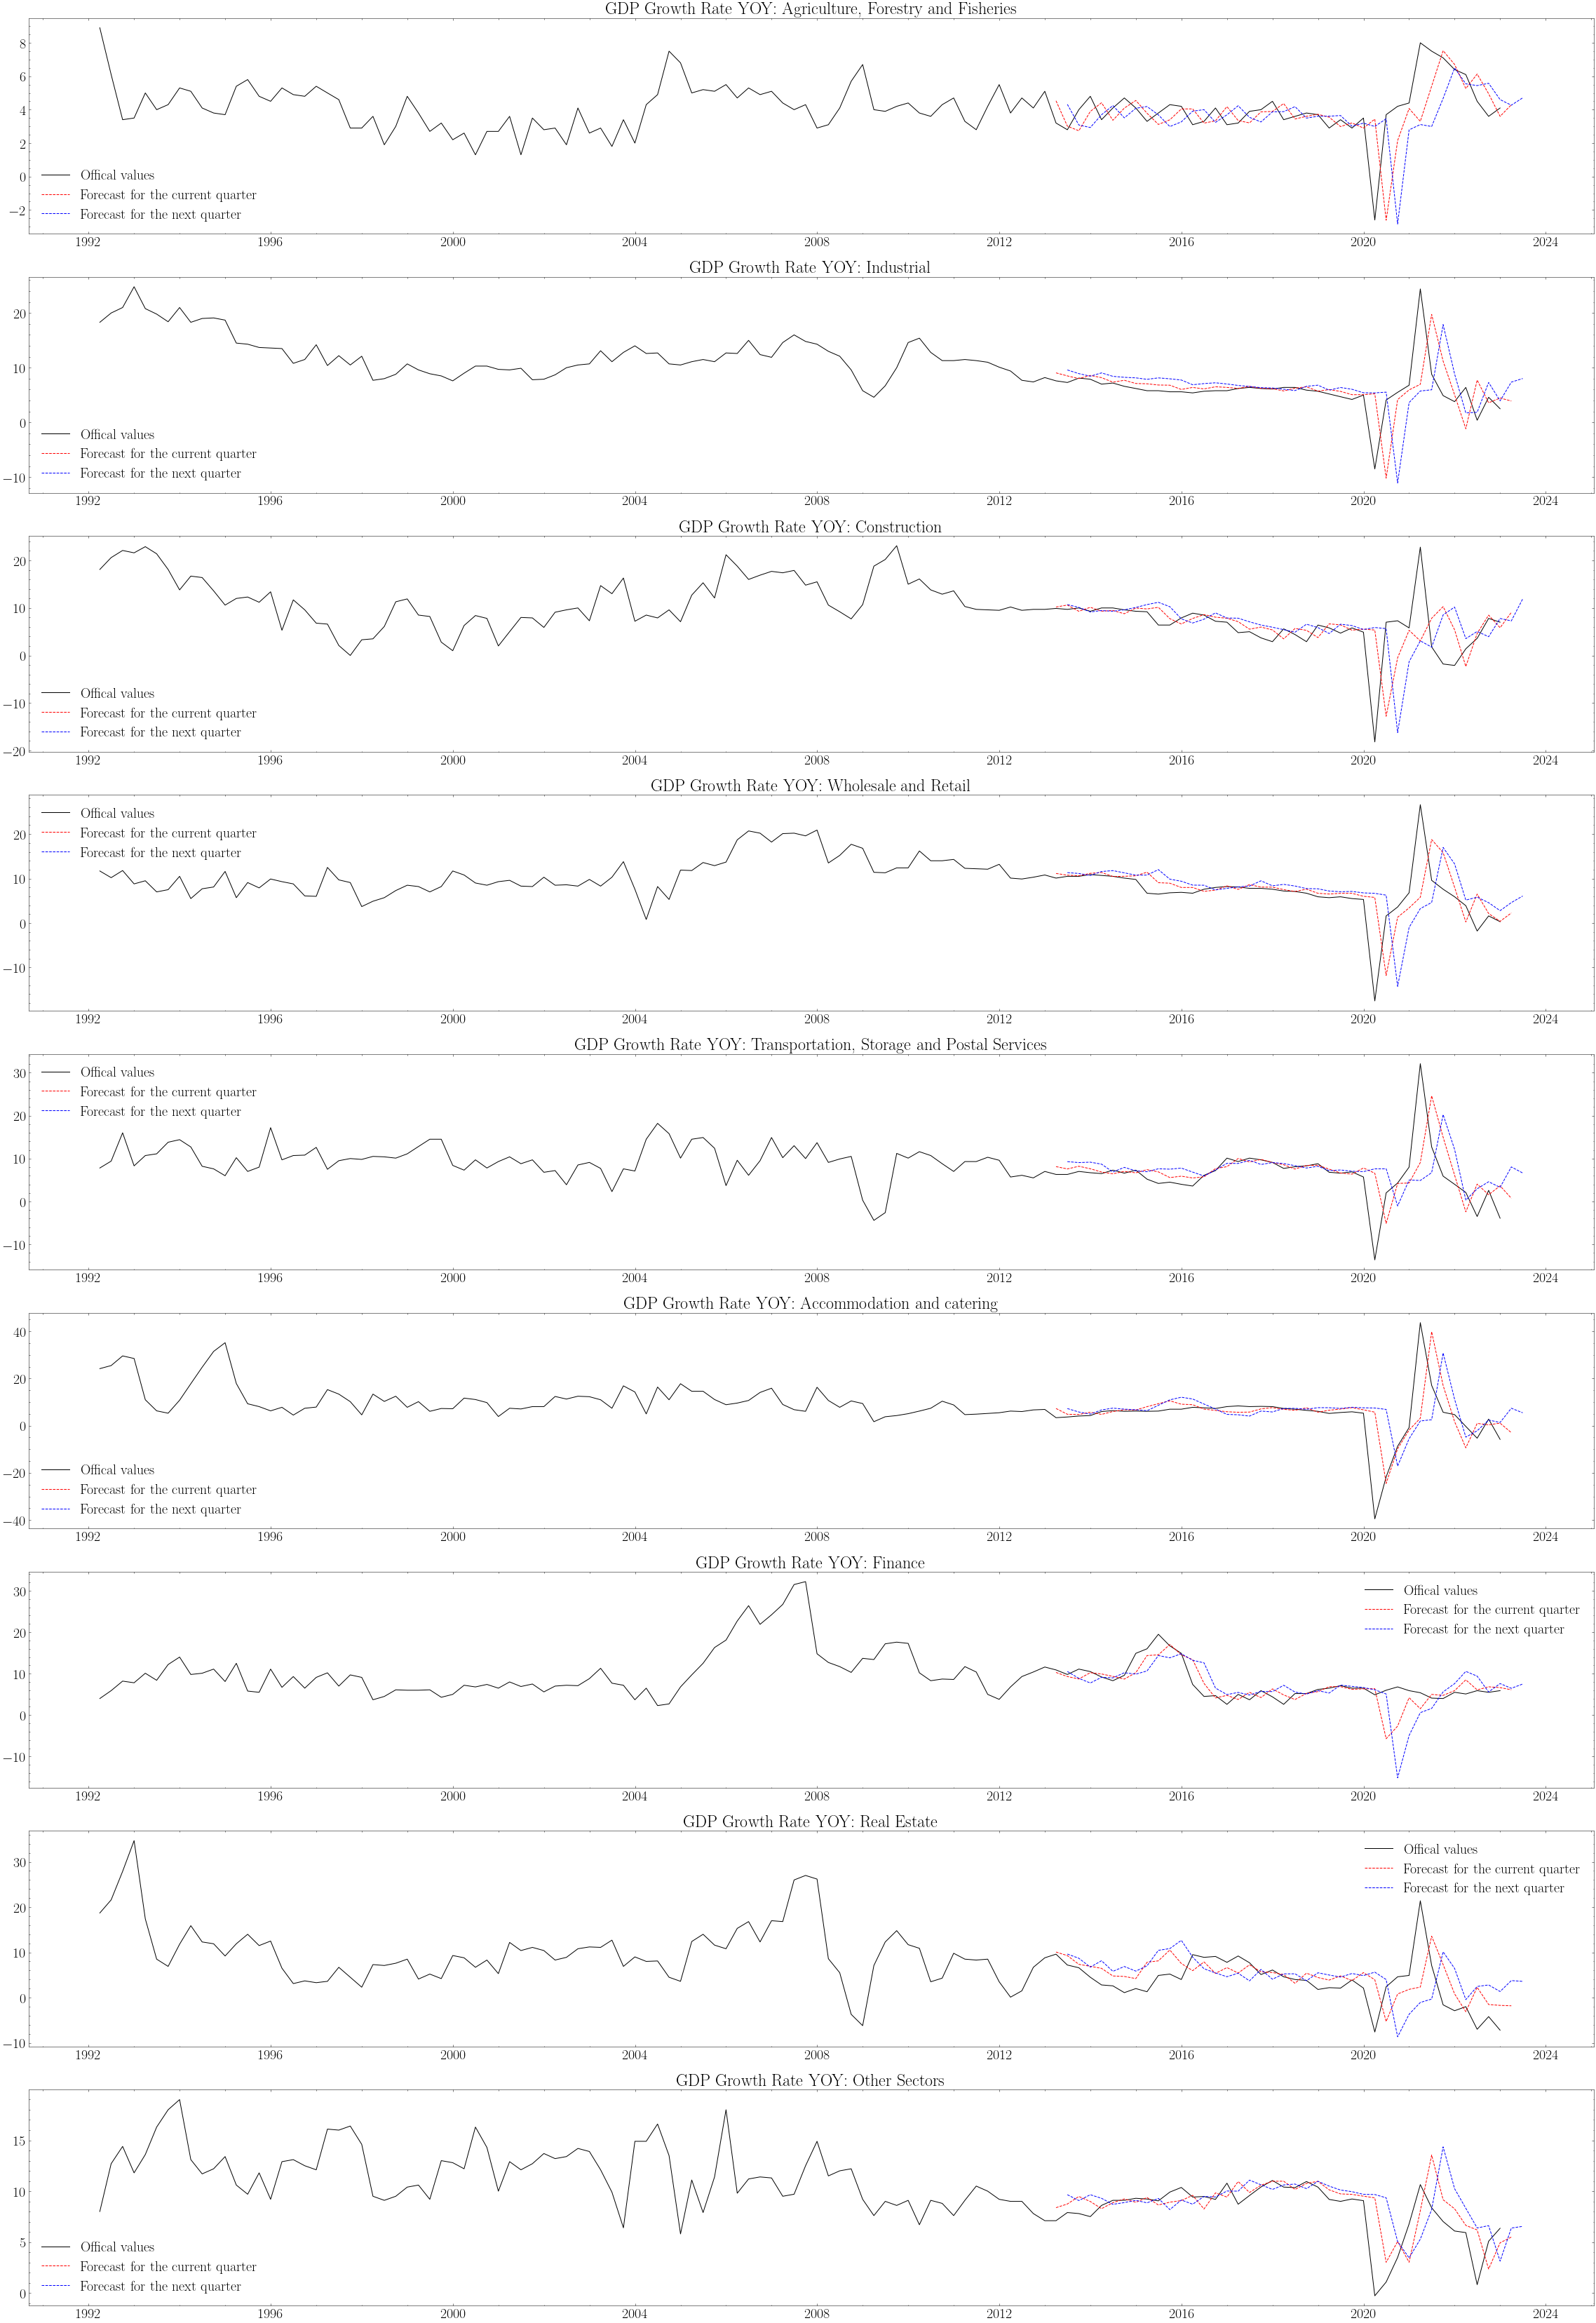

In [20]:
plt.style.use('science')
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.figsize'] = (20,8) 
plt.rcParams['font.size'] =  20.0
plt.rcParams['font.weight'] = 'bold'


fig, ax = plt.subplots(nrows=len(sectors_dict), figsize=(40, 60))
for i, count in zip(sectors_dict,range(9)):
    ax[count].plot(GDP_YOY_SECTORS.index, GDP_YOY_SECTORS[i], 'k-', label = 'Offical values')
    ax[count].plot(GDP_YOY_SECTORS_lag0.index, GDP_YOY_SECTORS_lag0[i], 'r--', label = 'Forecast for the current quarter')
    ax[count].plot(GDP_YOY_SECTORS_lag1.index, GDP_YOY_SECTORS_lag1[i], 'b--', label = 'Forecast for the next quarter')

    ax[count].set_title('GDP Growth Rate YOY: ' + sectors_dict[i])
    ax[count].legend()

plt.show()

In [35]:
for i in GDP_YOY_SECTORS.columns:
    a = r2_score(GDP_YOY_SECTORS['2013':'2019'][i] ,GDP_YOY_SECTORS_lag0['2013':'2019'][i])
    print(a)

-0.6640490314491145
0.2477590788438565
0.5626510043282875
0.46731894485452785
0.5169281906529557
-0.6130888003852681
0.7663285824263535
-0.06748261462224292
0.20713878310287115


In [36]:
GDP_YOY_SECTORS

,AR,ID,CO,WH,TR,AC,FI,RE,OT
QTR,,,,,,,,,
1992-03-31,8.9,18.3,18.1,11.7,7.8,24.2,4.0,18.7,8.000000
1992-06-30,6.1,20.0,20.6,10.2,9.4,25.5,5.9,21.6,12.700000
1992-09-30,3.4,21.0,22.1,11.8,16.0,29.6,8.2,27.9,14.400000
1992-12-31,3.5,24.8,21.6,8.8,8.3,28.5,7.8,34.7,11.800000
1993-03-31,5.0,20.8,22.9,9.5,10.7,11.0,10.1,17.4,13.600000
...,...,...,...,...,...,...,...,...,...
2021-12-31,6.4,3.8,-2.1,5.9,4.0,4.7,5.5,-2.9,6.085922
2022-03-31,6.1,6.4,1.4,3.9,2.1,-0.3,5.1,-2.0,5.928831
2022-06-30,4.5,0.4,3.6,-1.8,-3.5,-5.3,5.9,-7.0,0.814498


In [112]:
ALL_MACRO_DATA = pd.read_excel('全部宏观指标.xlsx', index_col = 0)
ALL_MACRO_DATA_DICT = pd.read_excel('全部宏观指标.xlsx', sheet_name = 1, index_col = 0).T
ALL_MACRO_DATA[ALL_MACRO_DATA_DICT[ALL_MACRO_DATA_DICT['频率']  == '日'].index] = ALL_MACRO_DATA[ALL_MACRO_DATA_DICT[ALL_MACRO_DATA_DICT['频率']  == '日'].index].fillna(method='ffill')
ALL_MACRO_DATA

,工业增加值:当月同比,全国国有企业:营业总收入:累计值,全国国有企业:利润总额:累计值,CPI:当月同比,RPI:当月同比,PPI:全部工业品:当月同比,进出口金额:当月值,贸易差额:当月值,实际使用外资金额:外商直接投资:当月值,固定资产投资完成额:累计值,...,产量:原煤:当月值,进口数量:原油:当月值,产量:铁矿石原矿量:当月值,进口数量:铁矿石:合计:当月值,土地购置费:累计值,房屋施工面积:累计值,房屋竣工面积:累计值,商品房销售面积:累计值,产量:乘用车:广义:当月值,零售销量:乘用车:广义:当月值
指标名称,,,,,,,,,,,,,,,,,,,,,
1991-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [113]:
ALL_MACRO_DATA.index = ALL_MACRO_DATA.index.to_period("M")
df_grouped = ALL_MACRO_DATA.groupby(ALL_MACRO_DATA.index)
ALL_MACRO_DATA_M = df_grouped.tail(1)
ALL_MACRO_DATA_M

,工业增加值:当月同比,全国国有企业:营业总收入:累计值,全国国有企业:利润总额:累计值,CPI:当月同比,RPI:当月同比,PPI:全部工业品:当月同比,进出口金额:当月值,贸易差额:当月值,实际使用外资金额:外商直接投资:当月值,固定资产投资完成额:累计值,...,产量:原煤:当月值,进口数量:原油:当月值,产量:铁矿石原矿量:当月值,进口数量:铁矿石:合计:当月值,土地购置费:累计值,房屋施工面积:累计值,房屋竣工面积:累计值,商品房销售面积:累计值,产量:乘用车:广义:当月值,零售销量:乘用车:广义:当月值
指标名称,,,,,,,,,,,,,,,,,,,,,
1991-01,23.5,NaN,NaN,2.2,1.4,NaN,NaN,NaN,NaN,NaN,...,8302.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-02,9.2,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,6412.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-03,10.9,NaN,NaN,1.6,0.9,NaN,NaN,NaN,NaN,NaN,...,8616.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-04,10.9,NaN,NaN,1.3,0.6,NaN,NaN,NaN,NaN,NaN,...,9066.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-05,10.9,NaN,NaN,3.6,3.1,NaN,NaN,NaN,NaN,NaN,...,9404.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10,5.0,664199.6,36196.9,2.1,2.3,-1.3,5113.40,849.40,130.4,471459.0,...,37009.5,4314.0,7267.5,9489.505594,36653.1651,888893.80,46564.58,111179.29,2315675.0,1866180.0
2022-11,2.2,730010.5,38595.9,1.6,1.8,-1.3,5213.47,690.56,97.4,520043.0,...,39130.6,4674.0,7953.6,9883.512643,39551.5768,896856.56,55708.82,121250.08,2136171.0,1673515.0
2022-12,1.3,825967.4,43148.2,1.8,2.0,-0.7,5341.45,780.13,110.5,572138.0,...,40269.3,4807.0,7861.2,9085.858265,41030.0123,904999.26,86222.22,135836.89,2144903.0,2192309.0


In [97]:
df_monthly_ends.iloc[-2][['即期汇率:美元兑人民币', '中债国债到期收益率:1年', '中债国债到期收益率:10年', '中债国开债到期收益率:1年',       '中债国开债到期收益率:10年', '银行间同业拆借加权利率:1天', '银行间同业拆借加权利率:3个月', '沪深300指数']]

即期汇率:美元兑人民币           6.7571
中债国债到期收益率:1年          2.1535
中债国债到期收益率:10年         2.8977
中债国开债到期收益率:1年         2.3009
中债国开债到期收益率:10年        3.0479
银行间同业拆借加权利率:1天        2.0828
银行间同业拆借加权利率:3个月       2.9303
沪深300指数            4156.8578
Name: 2023-01, dtype: float64

In [121]:
dir(ALL_MACRO_DATA_M.index.to_timestamp(freq='D') )

['T',
 '__abs__',
 '__add__',
 '__and__',
 '__annotations__',
 '__array__',
 '__array_priority__',
 '__array_ufunc__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__init__',
 '__init_subclass__',
 '__invert__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdivmod__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',
 '__rmod__',
 '__rmul__',
 '__ror__',
 '__rpow__',
 '__rsub__',
 '__rtruediv__',
 '__rxor__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',
 '__xor__',
 '_accessors',
 '_arith_method',
 